## Importing necessary libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

## Loading the dataset

In [7]:
df = pd.read_csv("Predicting Energy Consumption.csv")
df.head()

,Start time UTC,End time UTC,Electricity consumption (MWh)
0,31-12-2015 21:00,31-12-2015 22:00,10800
1,31-12-2015 22:00,31-12-2015 23:00,10431
2,31-12-2015 23:00,01-01-2016 00:00,10005
3,01-01-2016 00:00,01-01-2016 01:00,9722
4,01-01-2016 01:00,01-01-2016 02:00,9599


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52966 entries, 0 to 52965
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Start time UTC                 52966 non-null  object
 1   End time UTC                   52966 non-null  object
 2   Electricity consumption (MWh)  52966 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [9]:
df.describe()

,Electricity consumption (MWh)
count,52966.000000
mean,9488.750519
std,1576.241673
min,5341.000000
25%,8322.000000
50%,9277.000000
75%,10602.000000
max,15105.000000


## Datetime Conversion

In [10]:
df["Start time UTC"] = pd.to_datetime(df["Start time UTC"], dayfirst=True)
df["End time UTC"] = pd.to_datetime(df["End time UTC"], dayfirst=True)

The timestamps are converted to datetime objects so that time-based features like hour, day, and month can be extracted, which are crucial for capturing electricity usage patterns.

## Feature Engineering (Time-based features)

In [12]:
df["hour"] = df["Start time UTC"].dt.hour
df["day"] = df["Start time UTC"].dt.day
df["day_of_week"] = df["Start time UTC"].dt.dayofweek
df["month"] = df["Start time UTC"].dt.month
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

Electricity consumption follows strong daily, weekly, and seasonal patterns. These features help the model learn peak hours, weekday vs weekend behavior, and seasonal demand variations.

In [13]:
df.head()

,Start time UTC,End time UTC,Electricity consumption (MWh),hour,day,day_of_week,month,is_weekend
0,2015-12-31 21:00:00,2015-12-31 22:00:00,10800,21,31,3,12,0
1,2015-12-31 22:00:00,2015-12-31 23:00:00,10431,22,31,3,12,0
2,2015-12-31 23:00:00,2016-01-01 00:00:00,10005,23,31,3,12,0
3,2016-01-01 00:00:00,2016-01-01 01:00:00,9722,0,1,4,1,0
4,2016-01-01 01:00:00,2016-01-01 02:00:00,9599,1,1,4,1,0


### Duration in hours

In [14]:
df["duration_hours"] = (df["End time UTC"] - df["Start time UTC"]).dt.total_seconds() / 3600
df.head()

,Start time UTC,End time UTC,Electricity consumption (MWh),hour,day,day_of_week,month,is_weekend,duration_hours
0,2015-12-31 21:00:00,2015-12-31 22:00:00,10800,21,31,3,12,0,1.0
1,2015-12-31 22:00:00,2015-12-31 23:00:00,10431,22,31,3,12,0,1.0
2,2015-12-31 23:00:00,2016-01-01 00:00:00,10005,23,31,3,12,0,1.0
3,2016-01-01 00:00:00,2016-01-01 01:00:00,9722,0,1,4,1,0,1.0
4,2016-01-01 01:00:00,2016-01-01 02:00:00,9599,1,1,4,1,0,1.0


This feature captures the length of each consumption interval, ensuring the model accounts for variations in time duration between readings.

## Features and Target

In [15]:
X = df[["hour", "day", "day_of_week", "month", "is_weekend", "duration_hours"]]
y = df["Electricity consumption (MWh)"]

The feature matrix contains only explanatory time-based variables, while the target represents the electricity consumption to be predicted.

## Train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42372, 6), (10594, 6), (42372,), (10594,))

Shuffling is disabled to preserve temporal order, preventing data leakage and ensuring the model is evaluated on future data, which mirrors real-world forecasting scenarios.

## Model

In [19]:
model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

Gradient Boosting is chosen because it captures non-linear relationships effectively and performs well on structured tabular data with engineered features, without assuming linearity.

In [20]:
model.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,300
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


The model is trained on historical data to learn relationships between time-based features and electricity consumption.

## Evaluation of model

In [21]:
y_pred = model.predict(X_test)

In [22]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [23]:
print("Model Performance:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

Model Performance:
MAE  : 534.74
RMSE : 750.39
R²   : 0.7715


MAE and RMSE measure prediction error in the original units (MWh), while R² indicates how much variance in electricity consumption is explained by the model.

## Visualization

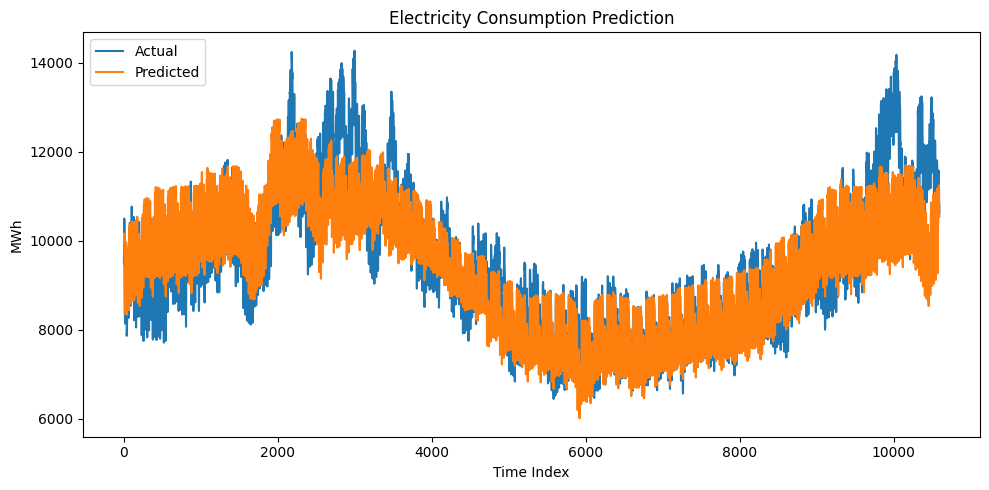

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Electricity Consumption Prediction")
plt.xlabel("Time Index")
plt.ylabel("MWh")
plt.legend()
plt.tight_layout()
plt.show()

Plotting actual versus predicted values helps visually assess how well the model captures overall trends and peak demand periods.